# Creating the dataset

In [39]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms as ttf
from torchvision import models
import numpy as np
import os
from PIL import Image

In [2]:


class DogsVdCatsDataSet(Dataset):
    def __init__(self, root, transform=None):
        """
        Args:
            root (string): Root folder of the dataset
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root=root
        self.transform = transform
        self.idx=os.listdir(self.root)


    def __len__(self):
        return len(self.idx)

    def __getitem__(self, idx):
        img_name=self.root+self.idx[idx]
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image=self.transform(image)
        label=int(self.idx[idx].startswith("dog"))
        return {"im":image, "label":label}

In [9]:
transform=ttf.Compose([
        ttf.RandomRotation(30),
        ttf.RandomHorizontalFlip(),
        ttf.RandomResizedCrop(224),
        ttf.ToTensor(),
        ttf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data=DogsVdCatsDataSet("/mnt/NAS/Trimbot/Data/catvsdogs/train/", transform)
train,val=torch.utils.data.random_split(data, [20000,5000])

SyntaxError: invalid syntax (<ipython-input-9-34562772f9e4>, line 6)

# Getting ready to train

In [4]:
from torch.utils.data import DataLoader
from torch import optim #the optimizer
from torch.nn import CrossEntropyLoss #Cross Entropy Loss: the learning criterion
from tqdm.notebook import tqdm #for visualization
use_cuda = True #Use GPU
n_epochs=100 #Train for 100 epochs
w_decay=1e-05 #Weight decay
l_rate=5*1e-04 #Learning rate
batch_size=64 
save_freq_epoch = 10 #Save the model every 10 epochs
trainloader = DataLoader( #The data loader!, same as for classification!
    train,
    batch_size=batch_size,
    num_workers=8,
    shuffle=True
)

## Loading the model

In [5]:
model=models.resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
model.fc=torch.nn.Linear(2048,2)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Let's train!

In [7]:
import tensorboard_logger
import datetime
import uuid

optimizer = optim.SGD(params=model.parameters(), lr=l_rate, weight_decay=w_decay)
loss=CrossEntropyLoss()
if use_cuda:
    model=model.cuda()


ustr = datetime.datetime.now().strftime("%y-%m-%d_%H-%M_") + uuid.uuid4().hex[:3]
logger = tensorboard_logger.Logger("tensorboard/" + "DogsVsCat" + '_' + ustr)
for e in tqdm(range(n_epochs)): #For all epochs
    for i,d in tqdm(enumerate(trainloader)): #Iterate all over the dataser
        optimizer.zero_grad() #Important: set gradients to 0 in every iteration

        if use_cuda:
            pred = model.forward(d["im"].cuda())#Forward
            err = loss.forward(pred, d["label"].cuda())#Loss
        else:
            pred = model.forward(d["im"])
            err = loss.forward(pred, d["label"])
        err.backward()#Backward
        logger.log_value('train_loss', err, e * len(trainloader) + i)
        optimizer.step()#Update everything
    if e % save_freq_epoch == 0:#Save the learnt model
        save_path =  "snapshots/" + "DogsVsCats" + '_' + ustr + "_" + str(e) + ".pth"
        torch.save(model.cpu().state_dict(), save_path)
        if use_cuda:
            model = model.cuda()
        

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Test and evaluate

In [35]:
from sklearn.metrics import accuracy_score
from torch.nn import Softmax


val.transform=ttf.Compose([
        ttf.Resize(224,),
        ttf.ToTensor(),
        ttf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
batch_size=8
valloader = DataLoader( #The data loader!, same as for classification!
    val,
    batch_size=batch_size,
    num_workers=8,
    shuffle=False
)

trainloader = DataLoader( #The data loader!, same as for classification!
    train,
    batch_size=batch_size,
    num_workers=8,
    shuffle=False
)

accs=[]
taccs=[]

for e in np.arange(0,n_epochs, save_freq_epoch):
    model.load_state_dict(torch.load("snapshots/DogsVsCats_20-01-11_17-46_41d_"+str(e)+".pth"))
    model=model.eval().cuda()
    preds=np.zeros(len(val),)
    gts=np.zeros(len(val),)

    for i,b in enumerate(valloader):  
        pred = model.forward(b["im"].cuda())#Forward
        pred = Softmax()(pred)
        pred=np.argmax(pred.cpu().detach().numpy(),axis=1)
        preds[i*batch_size:i*batch_size+batch_size]=pred
        gts[i*batch_size:i*batch_size+batch_size]=b["label"]
    acc=accuracy_score(gts,preds)
    accs.append([e,acc])
    trainpreds=np.zeros(len(train),)
    traingts=np.zeros(len(train),)
    train.transform=val.transform
    for i,b in enumerate(trainloader):  
        pred = model.forward(b["im"].cuda())#Forward
        pred = Softmax()(pred)
        pred=np.argmax(pred.cpu().detach().numpy(),axis=1)
        trainpreds[i*batch_size:i*batch_size+batch_size]=pred
        traingts[i*batch_size:i*batch_size+batch_size]=b["label"]
    tacc=accuracy_score(traingts,trainpreds)
    taccs.append([e,tacc])

/home/maria/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/maria/.local/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 80.0 Accuracy: 0.9778


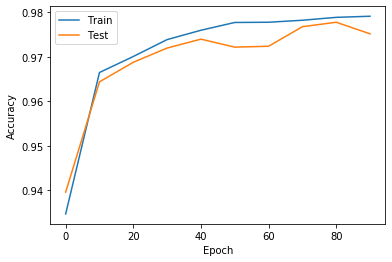

In [43]:
import matplotlib.pyplot as plt
accs=np.array(accs)
taccs=np.array(taccs)
plt.plot(taccs[:,0], taccs[:,1], label="Train")

plt.plot(accs[:,0], accs[:,1], label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

best_epoch=np.argmax(accs[:,1])
print("Epoch:",str(accs[best_epoch,0]),"Accuracy:",str(accs[best_epoch,1]))